# 07. 최종 보고서 및 프로젝트 종합

**목표**: 프로젝트 전체 요약 및 실시간 예측 데모

## 📋 목차

1. Executive Summary
2. 프로젝트 개요
3. 데이터 및 Feature Engineering
4. 모델링 결과
5. 핵심 발견사항 (Key Findings)
6. 비즈니스 활용 방안
7. 실시간 예측 데모
8. 한계점 및 개선 방향
9. 결론

## 1. Executive Summary

### 프로젝트 개요

**문제 정의**: 영화 산업에서 흥행 예측은 투자 및 마케팅 의사결정의 핵심  
**목표**: KOBIS API와 Naver 검색 트렌드를 활용한 영화 총 관객수 예측 모델 구축

### 데이터
- KOBIS 박스오피스 데이터 (N편)
- 영화 상세 정보 (장르, 감독, 배우, 배급사 등)
- Naver 검색 트렌드 (개봉 4주 전 ~ 1주 후)

### 최종 모델
- **알고리즘**: [최종 선정 모델]
- **성능**: Test R² = [값], RMSE = [값]만 명

### 핵심 발견
1. **검색 트렌드의 중요성**: 개봉 2주 전 검색량이 강력한 예측 변수
2. **Ticket Power 효과**: 감독/배우의 과거 성적도 유의미한 영향
3. **장르 및 시즌 효과**: 특정 장르와 성수기가 관객수에 영향

## 2. 프로젝트 상세

In [29]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False

sys.path.append('..')

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [30]:
# 모든 결과 데이터 로드
try:
    model_comparison = pd.read_csv('results/tables/model_comparison.csv', index_col=0)
    print("model_comparison 로드 완료!")
except Exception as e:
    print(f"model_comparison 로드 실패: {e}")

try:
    baseline_results = pd.read_csv('results/tables/baseline_results.csv')
    print("baseline_results 로드 완료!")
except Exception as e:
    print(f"baseline_results 로드 실패: {e}")

try:
    feature_importance = pd.read_csv('results/feature_importance.csv')
    print("feature_importance 로드 완료!")
except Exception as e:
    print(f"feature_importance 로드 실패: {e}")

model_comparison 로드 완료!
baseline_results 로드 완료!
feature_importance 로드 완료!


### 2.1 데이터 수집

In [31]:
# 데이터 현황
movie_features = pd.read_csv('data/processed/movie_features.csv')

print("=== 데이터 현황 ===")
print(f"총 영화 수: {len(movie_features)} 편")
print(f"총 Feature 수: {len(movie_features.columns)}")
print(f"\n관객수 통계:")
print(f"  평균: {movie_features['audiAcc'].mean():,.0f} 명")
print(f"  중앙값: {movie_features['audiAcc'].median():,.0f} 명")
print(f"  최대: {movie_features['audiAcc'].max():,.0f} 명")
print(f"  최소: {movie_features['audiAcc'].min():,.0f} 명")

=== 데이터 현황 ===
총 영화 수: 1252 편
총 Feature 수: 60

관객수 통계:
  평균: 509,393 명
  중앙값: 28,340 명
  최대: 13,977,409 명
  최소: 259 명


### 2.2 Feature Engineering 요약

In [32]:
# Feature 설명 파일 읽기
with open('data/processed/feature_description.txt', 'r', encoding='utf-8') as f:
    feature_desc = f.read()

feature_cols = [line.split('. ')[1] for line in feature_desc.split('\n')[2:] if line.strip()]

print("=== 생성된 Feature 그룹 ===")
print(f"1. 검색 트렌드: {len([c for c in feature_cols if 'search' in c])}개")
print(f"2. Ticket Power: {len([c for c in feature_cols if 'power' in c])}개")
print(f"3. 장르: {len([c for c in feature_cols if c.startswith('genre_')])}개")
print(f"4. 시간/시즌: {len([c for c in feature_cols if 'release' in c or c.startswith('season_')])}개")
print(f"5. 기타: {len(feature_cols) - sum([len([c for c in feature_cols if x in c]) for x in ['search', 'power']])}개")

=== 생성된 Feature 그룹 ===
1. 검색 트렌드: 9개
2. Ticket Power: 3개
3. 장르: 22개
4. 시간/시즌: 8개
5. 기타: 34개


## 3. 모델링 결과

In [33]:
# 모델 비교 결과
print("=== 모델 성능 비교 ===")
print(model_comparison[['Val_R2', 'Val_RMSE', 'Val_MAE']])

# 최종 모델
best_model = joblib.load('models/best_model.pkl')
best_model_name = type(best_model).__name__

print(f"\n🏆 최종 선정 모델: {best_model_name}")

=== 모델 성능 비교 ===
                           Val_R2      Val_RMSE        Val_MAE
LightGBM (기본)            0.465402  1.323662e+06  425424.998629
Random Forest (기본)       0.394844  1.408307e+06  433543.060054
Tuned Random Forest      0.369800  1.437151e+06  434057.533098
Gradient Boosting (기본)   0.298789  1.515961e+06  481693.454218
Tuned Gradient Boosting  0.298789  1.515961e+06  481693.454218
Ridge                    0.496723  1.284301e+06  604348.796562

🏆 최종 선정 모델: LGBMRegressor


In [34]:
import numpy as np
# Test 성능 (06 노트북에서 평가한 결과)
X_test = pd.read_csv('data/final/X_test.csv')
y_test = pd.read_csv('data/final/y_test.csv')['audiAcc']

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== 최종 Test 성능 ===")
print(f"RMSE: {test_rmse:,.0f} 명")
print(f"MAE:  {test_mae:,.0f} 명")
print(f"R²:   {test_r2:.3f}")


=== 최종 Test 성능 ===
RMSE: 1,136,763 명
MAE:  337,351 명
R²:   0.524


## 4. 핵심 발견사항 (Key Findings)

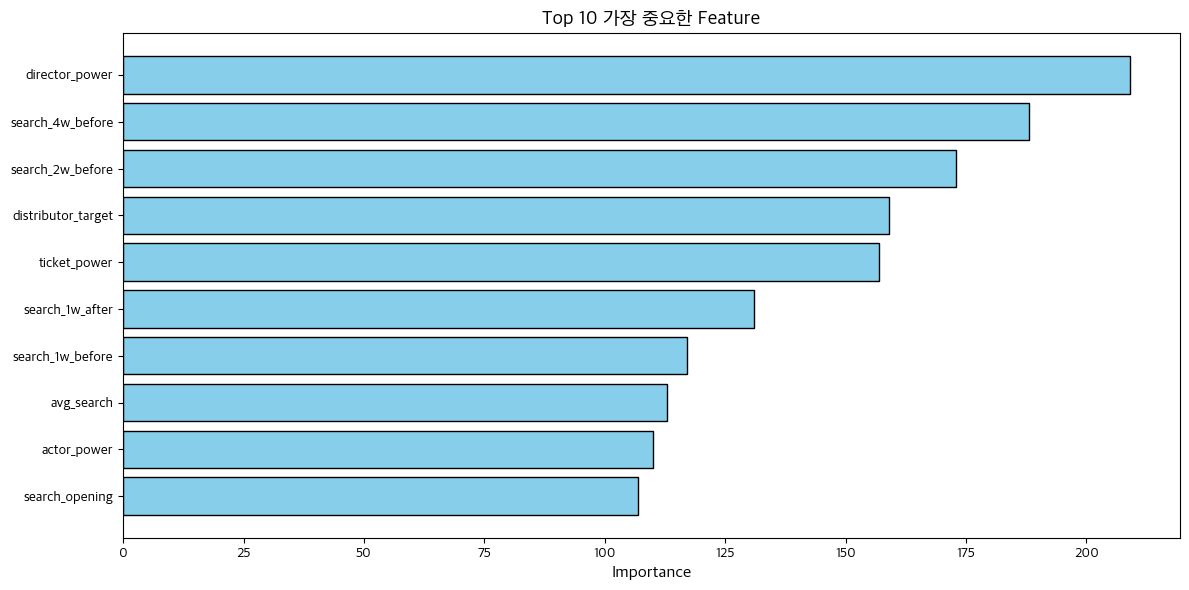


=== Top 10 중요 Feature ===
 1. director_power                 : 209.0000
 2. search_4w_before               : 188.0000
 3. search_2w_before               : 173.0000
 4. distributor_target             : 159.0000
 5. ticket_power                   : 157.0000
 6. search_1w_after                : 131.0000
 7. search_1w_before               : 117.0000
 8. avg_search                     : 113.0000
 9. actor_power                    : 110.0000
10. search_opening                 : 107.0000


In [35]:
# Feature Importance 시각화
if hasattr(best_model, 'feature_importances_'):
    top_10 = feature_importance.head(10)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_10)), top_10['importance'], color='skyblue', edgecolor='black')
    plt.yticks(range(len(top_10)), top_10['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 10 가장 중요한 Feature', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n=== Top 10 중요 Feature ===")
    for i, row in top_10.iterrows():
        print(f"{i+1:2d}. {row['feature']:30s} : {row['importance']:.4f}")